# A simple Movie Recommendation process based on plot description

### Goal of the project



### Motivation for this project



### Practical application



<font color='maroon'>

### Outline of the entire process:



In [36]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
import tensorflow as tf
import tensorflow_hub as hub

In [38]:
import cv2
import urllib.request
import requests

In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityajakka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

### STEP 1

In [41]:
new_df = pd.read_csv('clean_data.csv')

In [42]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0    imdb_id               original_title  \
0           0  tt0114709                    Toy Story   
1           1  tt0113497                      Jumanji   
2           2  tt0113228             Grumpier Old Men   
3           3  tt0114885            Waiting to Exhale   
4           4  tt0113041  Father of the Bride Part II   

                     genres                                      modified_desc  
0   Animation,Comedy,Family  led woody andy's toys live happily room andy's...  
1  Adventure,Fantasy,Family  siblings judy peter discover enchanted board g...  
2            Romance,Comedy  family wedding reignites ancient feud next-doo...  
3      Comedy,Drama,Romance  cheated mistreated stepped women holding breat...  
4                    Comedy  george banks recovered daughter's wedding rece...

In [43]:
new_df = new_df.drop('Unnamed: 0', axis =1)

In [44]:
new_df = new_df.reset_index(drop = True)

In [45]:
len(new_df)

27412

In [46]:
data = new_df.dropna()

In [47]:
len(data)

25750

In [48]:
genres_list = []

In [49]:
for j in data['genres']:     #Looping over the genres column of the dataframe.
    words = j.split(',')            #The different genres have been separated by a comma. Hence this string will be split by identifying the ',' character.
    for k in words:                 #Since the different list of words will be identified, the for loop will be used to iterate through all the different words in this list.
        if k not in genres_list:    #Only uniquely identified strings will be appended.
            genres_list.append(k)

In [50]:
genres_list

['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Science',
 'Fiction',
 'Mystery',
 'War',
 'Music',
 'TV',
 'Movie']

In [51]:
data.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                       modified_desc  
0  led woody andy's toys live happily room andy's...  
1  siblings judy peter discover enchanted board g...  
2  family wedding reignites ancient feud next-doo...  
3  cheated mistreated stepped women holding breat...  
4  george banks recovered daughter's wedding rece...

In [52]:
data = data.reset_index(drop = True)

In [53]:
data.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                       modified_desc  
0  led woody andy's toys live happily room andy's...  
1  siblings judy peter discover enchanted board g...  
2  family wedding reignites ancient feud next-doo...  
3  cheated mistreated stepped women holding breat...  
4  george banks recovered daughter's wedding rece...

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [54]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

In [55]:
embed = hub.Module(module_url)

In [56]:
all_descriptions = data['modified_desc'].tolist()

In [57]:
len(all_descriptions)

25750

In [58]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [59]:
with tf.device('/device:CPU:0'):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings = session.run(embed(all_descriptions))

In [60]:
len(description_embeddings)

25750

In [61]:
len(description_embeddings[0])

512

In [62]:
len(description_embeddings[1])

512

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [63]:
cos_matrix = cosine_similarity(description_embeddings)

In [64]:
cos_matrix.shape

(25750, 25750)

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [65]:
words_siilar = cos_matrix

In [66]:
words_siilar.shape

(25750, 25750)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [67]:
KEY = 'a997c6a74e5b2d33c1e329b556a1769d'

In [88]:
def get_images(imdb_id):
    IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' # The URL pattern for the movie posters. With the key and IMDB ID, the generated URL can be used to download the posters.
    r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=imdb_id)) # KEY is the API key and i[0] identifies the unique IMDB ID.
    api_response = r.json() # The generated response is converted to json.
    
    try:                    # Some of the movies do not contain any information and much less, any posters. Hence, exception handling will be used to avoid errors during runtime
        
        posters = api_response['posters'] # Contains information about the movie posters to be downloaded.
    except KeyError:
        pass
       # print('error for ' + imdb_id)
                  # 'continue' can only be used in a loop. This command moves on the next row if no vible information is found.
    
    base_url = 'http://image.tmdb.org/t/p/'  # The base url for the TMDB API
    max_size = 'w342'                        # Movie sizes are available in different sizes: w342, w500, and orignal. w342 images are smaller than w500 and 'original' images.
    try:                                     # Some movies do not have posters and hence, exception handling will be used to avoid runtime errors
       
        rel_path = posters[0]['file_path']   # Some movies have multiple posters. A few movies have up to 9 posters or so. What's even more bothersome is that some of them are duplicates. Hence, onlyone image per movie will be used.
    except IndexError:
        pass
    url = "{0}{1}{2}".format(base_url, max_size, rel_path) # If the movie does have a poster, this step generated the movie poster url
    #print(url)
    
    try:                                                          #Exception handling will be used since some of the URLs will not open or throw an error.
        resp = urllib.request.urlopen(url)                        # This step read the image from the url
        image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
        #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
        new_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except urllib.error.URLError as e:
        print(e.reason)
    return new_img

In [89]:
poster = get_images('tt0114709')

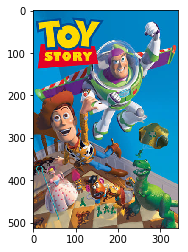

In [90]:
plt.imshow(poster)

In [91]:
def get_related_movies(imdbid, data = data):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    movie = data.loc[data.imdb_id == imdbid].index
    index_list = []
    for k in movie:
        index_list.append(k)
    index_num = index_list[0]
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:13] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    #print(similar_prod_arr)
    prod_img = get_images(imdbid) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,16))
    plt.subplot(5,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        img = get_images(data['imdb_id'].loc[i]) # Retrieves the images of all items related to the product
        plt.subplot(5,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related movie ID: ' + str(i))
        j+=1

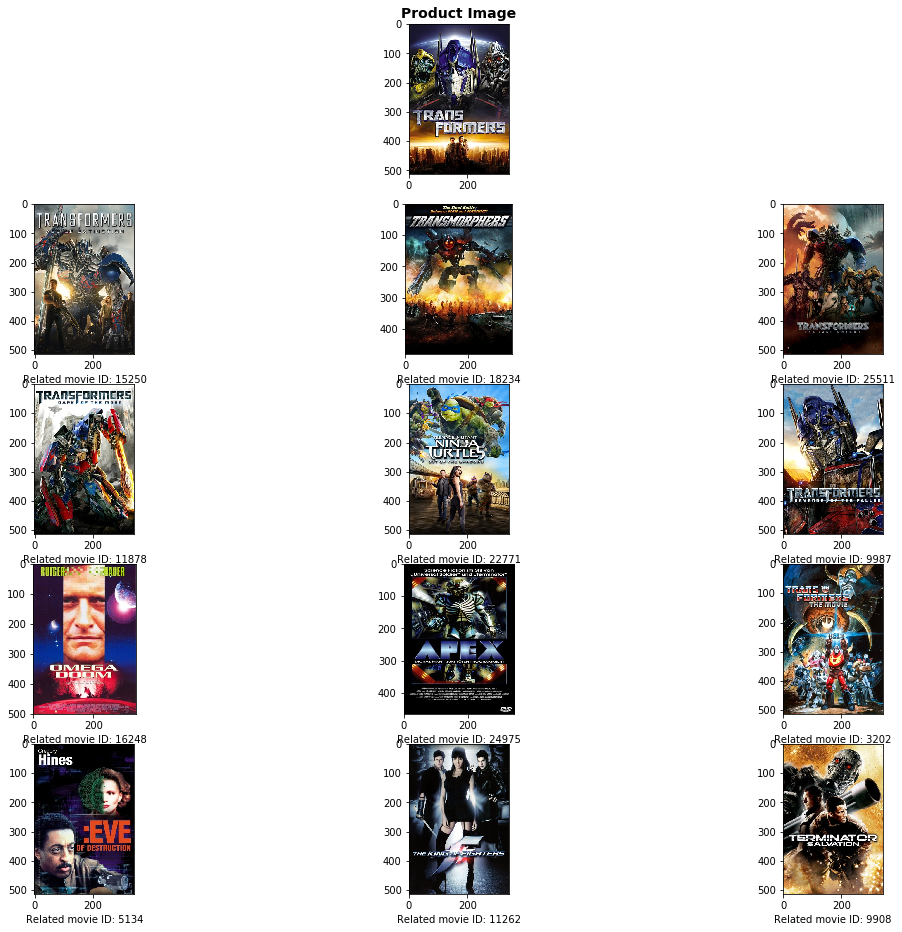

In [92]:
get_related_movies('tt0418279')

In [74]:
data.loc[8816]

imdb_id                                                   tt0418279
original_title                                         Transformers
genres                             Adventure,Science,Fiction,Action
modified_desc     young teenager sam witwicky becomes involved a...
Name: 8816, dtype: object

In [38]:
data['genres'].loc[[8816,16248, 24975, 5134, 11262, 9908]]

8816     Adventure,Science,Fiction,Action
16248                     Science,Fiction
24975              Science,Fiction,Action
5134               Action,Science,Fiction
11262     Action,Thriller,Science,Fiction
9908      Action,Science,Fiction,Thriller
Name: genres, dtype: object

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

In [40]:
data['genres'].loc[[12335, 10559, 12593, 16519, 2290]]

12335    Adventure,Fantasy,Romance
10559     Adventure,Fantasy,Family
12593                 Music,Comedy
16519             Animation,Family
2290             Fantasy,Adventure
Name: genres, dtype: object

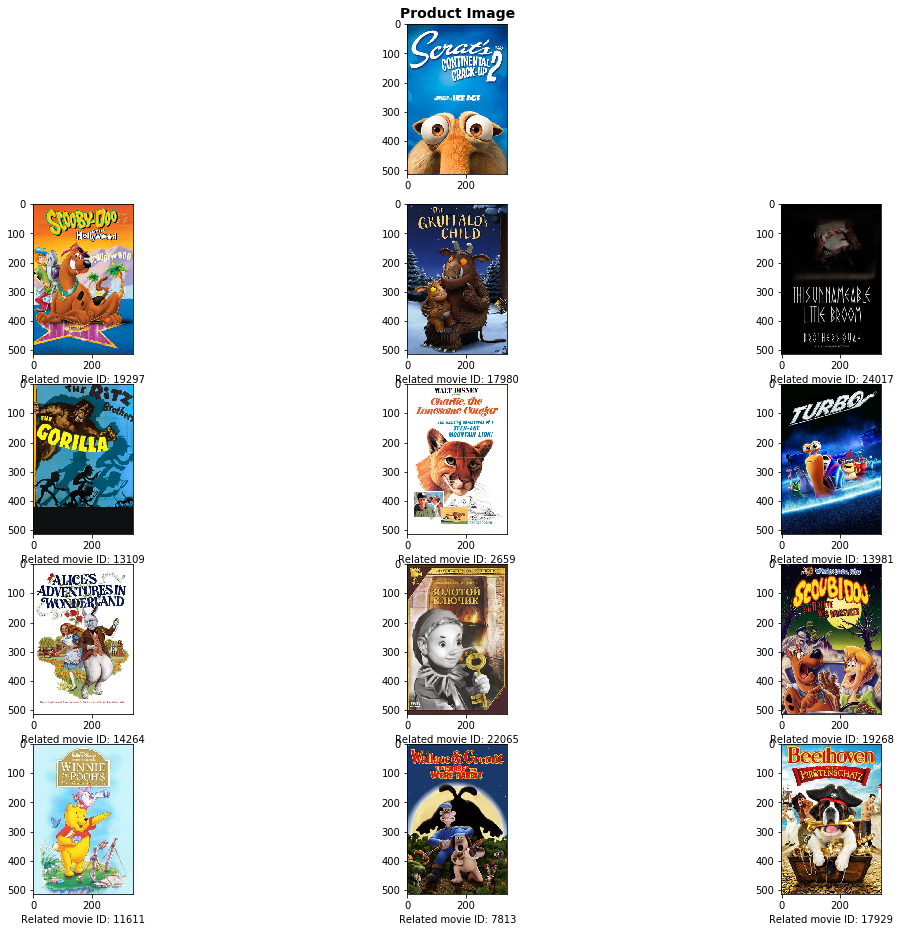

In [94]:
get_related_movies('tt2115386')

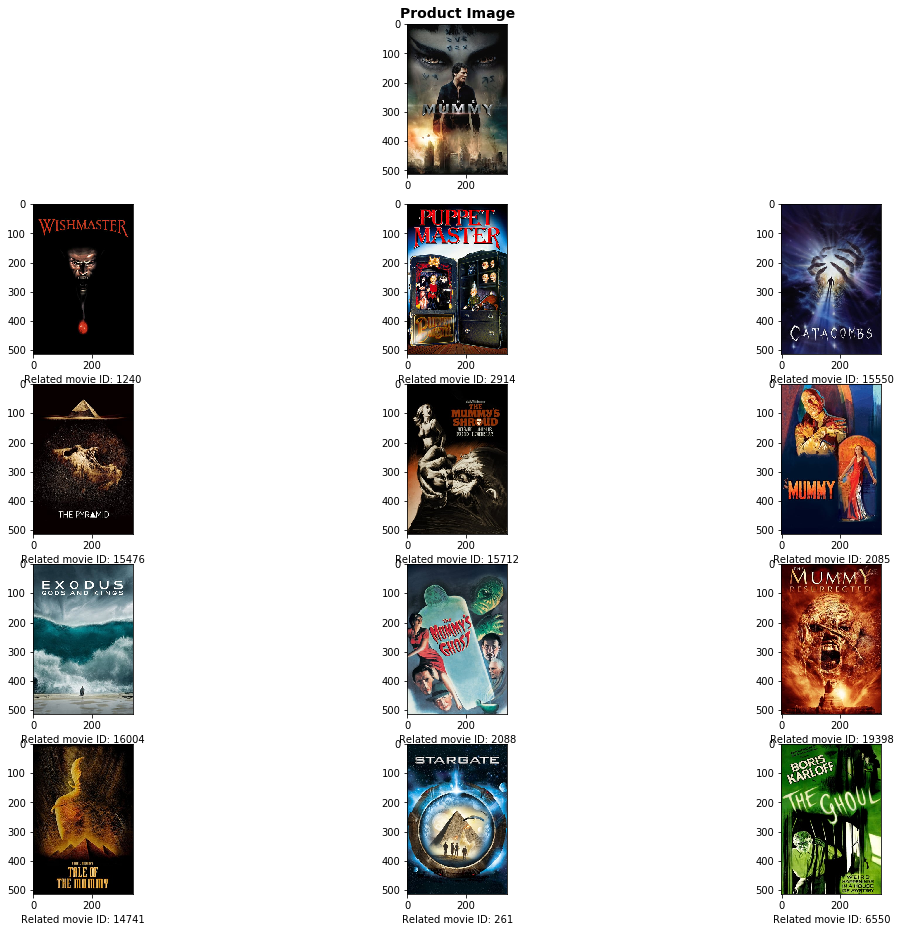

In [95]:
get_related_movies('tt2345759')

In [96]:
data['genres'].loc[[1240, 2914, 15550, 15712, 6550]]

1240                                  Horror
2914                                  Horror
15550                                 Horror
15712                                 Horror
6550     Romance,Drama,Horror,Action,Mystery
Name: genres, dtype: object

In [102]:
data.loc[data.imdb_id == 'tt0429493']

imdb_id original_title                                  genres  \
10841  tt0429493     The A-Team  Thriller,Action,Adventure,Comedy,Crime   

                                           modified_desc  
10841  group iraq war veterans goes run us military f...

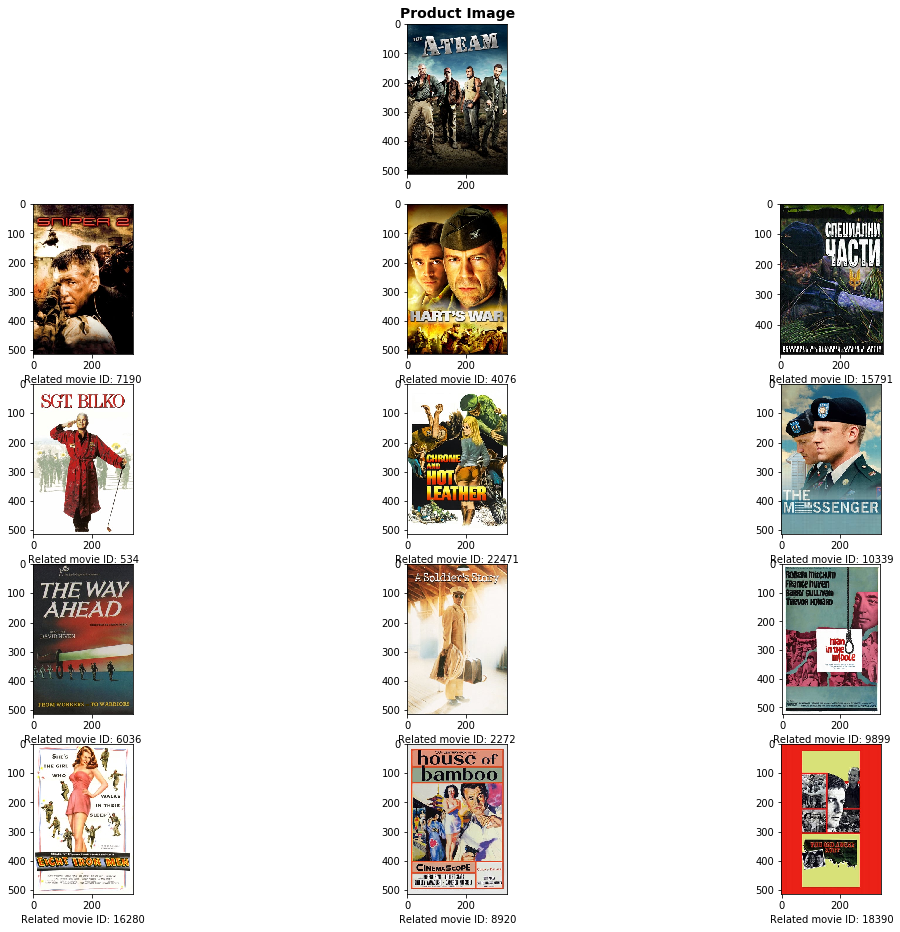

In [100]:
get_related_movies('tt0429493')

In [101]:
data['genres'].loc[[15791,534, 22471, 2272, 9899, 16280, 8920, 18390]]

15791    War,Action,Thriller
534            Comedy,Family
22471        Action,Thriller
2272       Drama,Mystery,War
9899                     War
16280              Drama,War
8920             Crime,Drama
18390                    War
Name: genres, dtype: object

In [103]:
data.loc[data.original_title.str.contains('Inception')]

imdb_id original_title  \
10916  tt1375666      Inception   

                                                  genres  \
10916  Action,Thriller,Science,Fiction,Mystery,Adventure   

                                           modified_desc  
10916  cobb skilled thief commits corporate espionage...

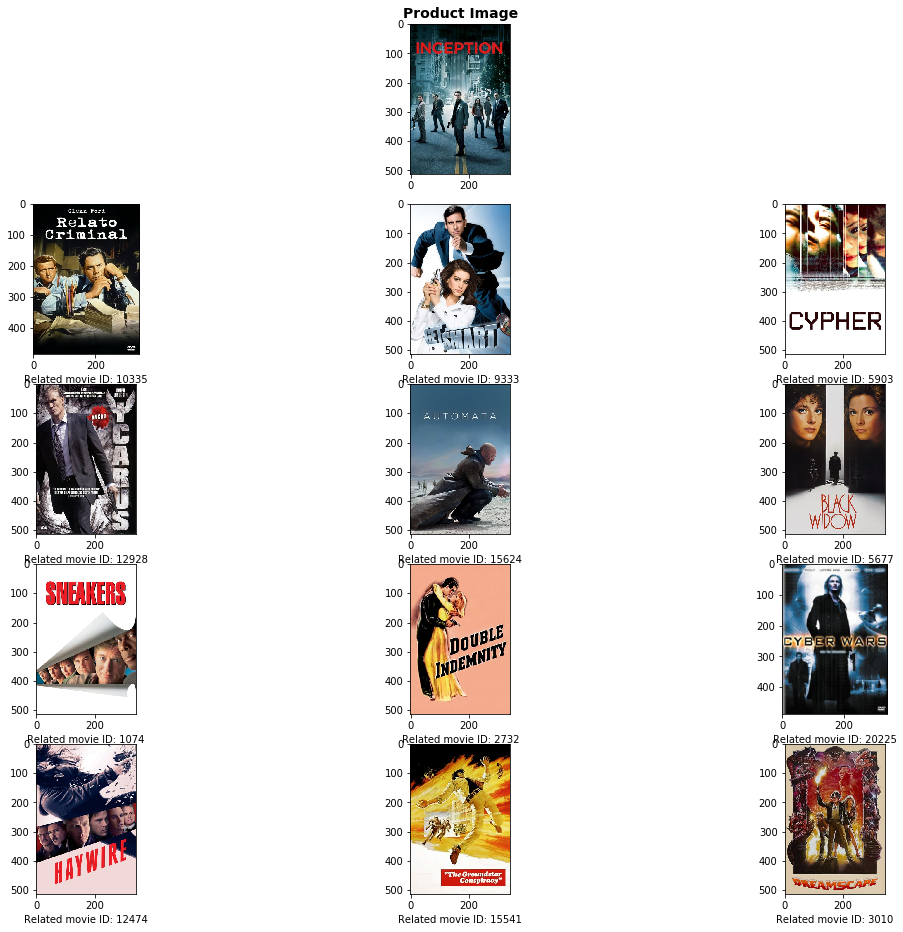

In [104]:
get_related_movies('tt1375666')

In [106]:
data['genres'].loc[[10335, 9333, 12928, 15624, 5677, 1074, 2732, 20225, 15541, 3010]]

10335                                  Crime,Drama
9333                        Action,Comedy,Thriller
12928                        Action,Drama,Thriller
15624                     Thriller,Science,Fiction
5677                              Mystery,Thriller
1074                            Comedy,Crime,Drama
2732                        Drama,Mystery,Thriller
20225        Action,Drama,Science,Fiction,Thriller
15541                         Action,Crime,Mystery
3010     Adventure,Horror,Science,Fiction,Thriller
Name: genres, dtype: object

In [114]:
data.loc[data.original_title.str.contains('Step Brothers')]

imdb_id original_title  genres  \
9393  tt0838283  Step Brothers  Comedy   

                                          modified_desc  
9393  brennan huff dale doback might grown men stop ...

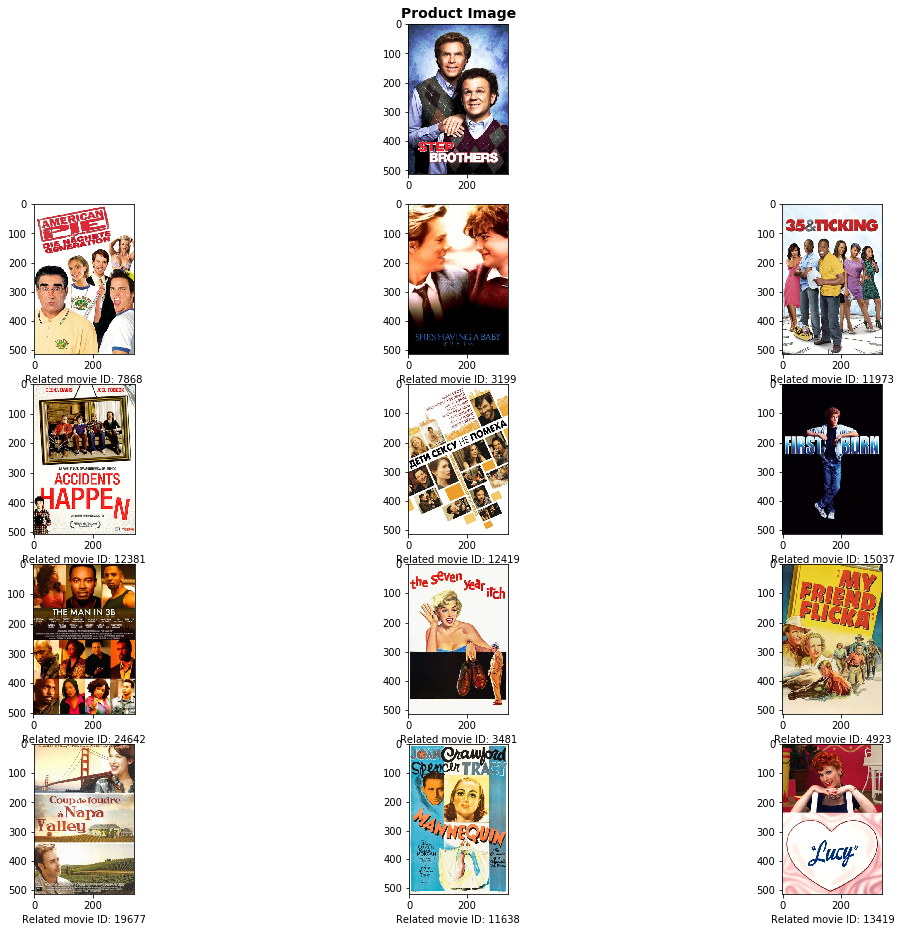

In [115]:
get_related_movies('tt0838283')

In [116]:
data['genres'].loc[[3199, 11973, 12381, 12419, 15037, 24642, 4923, 19677, 11638, 13419]]

3199              Comedy,Drama,Romance
11973                   Romance,Comedy
12381                     Comedy,Drama
12419             Comedy,Drama,Romance
15037                            Drama
24642                          Mystery
4923     Action,Adventure,Drama,Family
19677             Drama,Comedy,Romance
11638                            Drama
13419                   TV,Movie,Drama
Name: genres, dtype: object

In [117]:
data.loc[data.original_title.str.contains('Guardians of')]

imdb_id                  original_title  \
15327  tt2015381         Guardians of the Galaxy   
17043  tt3896198  Guardians of the Galaxy Vol. 2   

                                        genres  \
15327         Action,Science,Fiction,Adventure   
17043  Action,Adventure,Comedy,Science,Fiction   

                                           modified_desc  
15327  light years earth 26 years abducted peter quil...  
17043  guardians must fight keep newfound family toge...

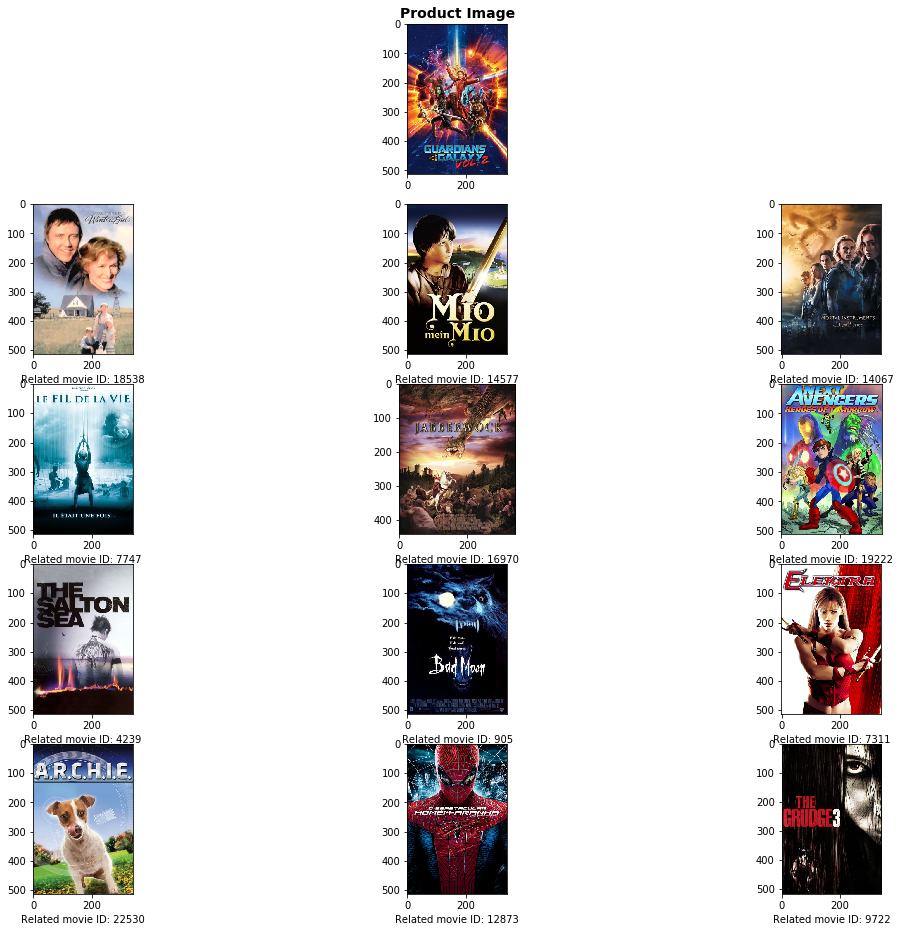

In [118]:
get_related_movies('tt3896198')

In [120]:
data.loc[data.original_title.str.contains('The Silence of the Lambs')]

imdb_id            original_title                genres  \
502  tt0102926  The Silence of the Lambs  Crime,Drama,Thriller   

                                         modified_desc  
502  fbi trainee clarice starling ventures maximum-...

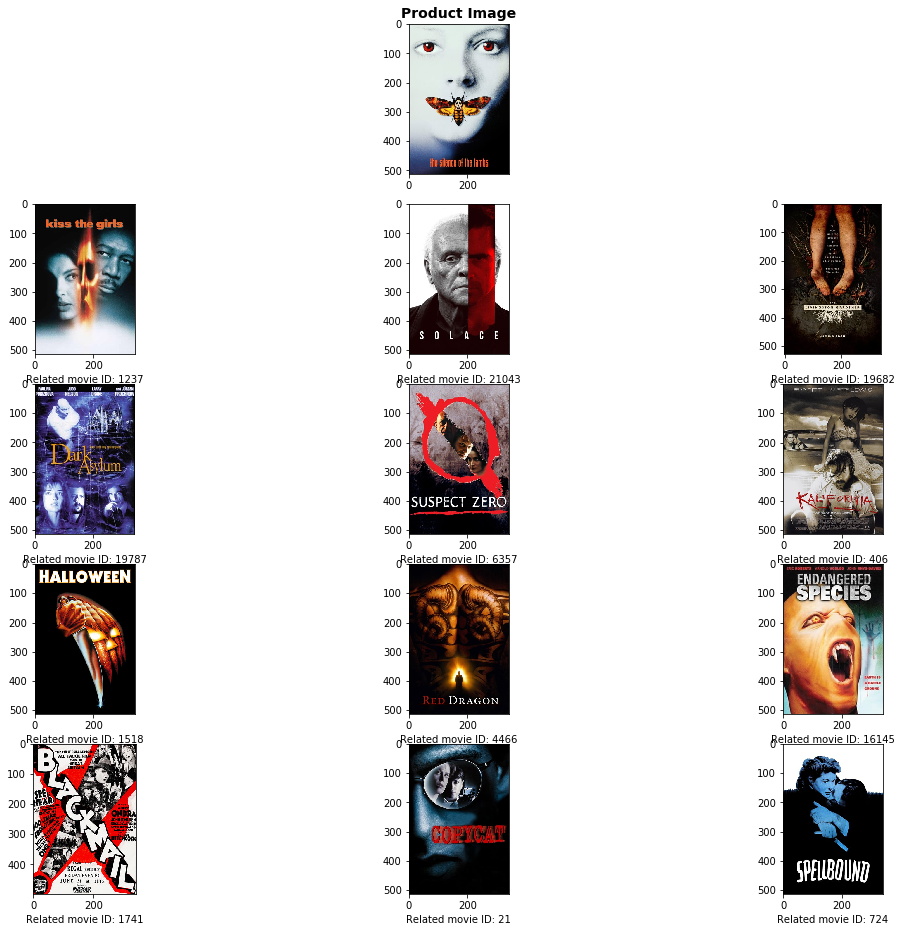

In [121]:
get_related_movies('tt0102926')

In [124]:
data['genres'].loc[[1237, 21043, 19682, 1518, 16145, 1741, 21, 724]]

1237        Drama,Mystery,Thriller,Crime
21043                Crime,Drama,Mystery
19682                      Drama,Mystery
1518                     Horror,Thriller
16145    Science,Fiction,Horror,Thriller
1741                Drama,Thriller,Crime
21                        Drama,Thriller
724               Drama,Mystery,Thriller
Name: genres, dtype: object

In [122]:
data.loc[data.original_title.str.contains('The Fault in Our Stars')]

imdb_id          original_title         genres  \
15177  tt2582846  The Fault in Our Stars  Romance,Drama   

                                           modified_desc  
15177  despite tumor-shrinking medical miracle bought...

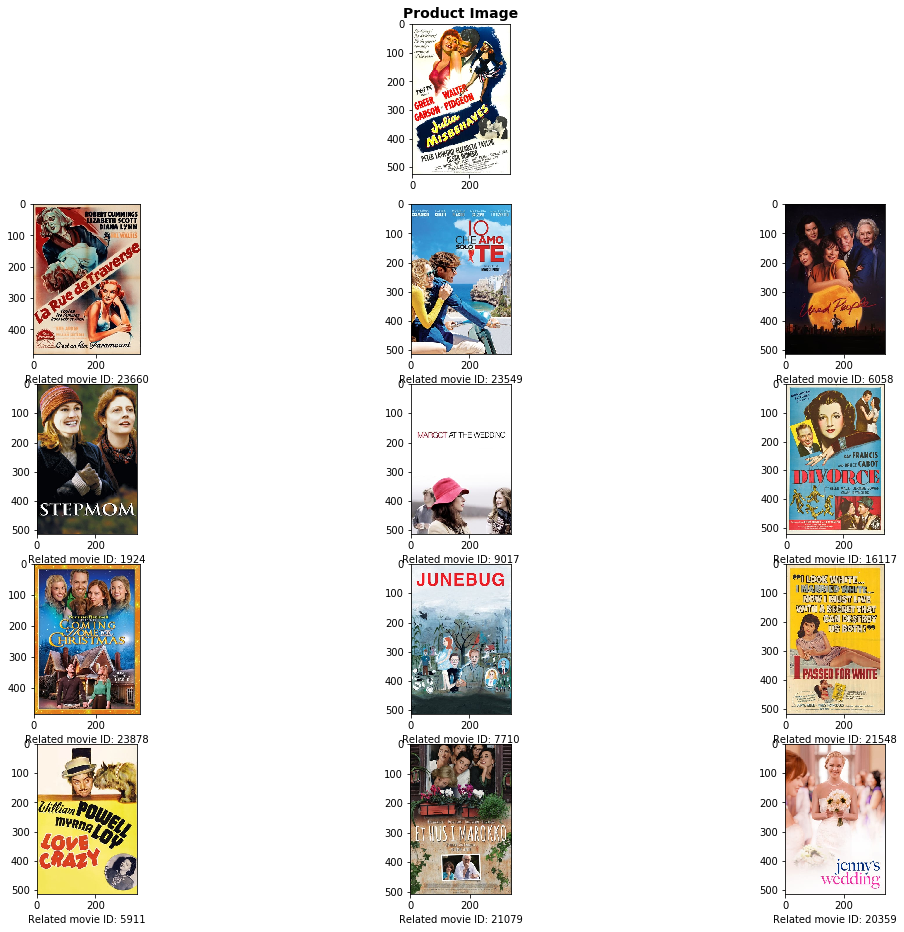

In [128]:
get_related_movies('tt0040498')

In [129]:
data['genres'].loc[[23660, 23549, 6058, 1924, 9017, 16117,7710, 5911, 21079, 20359]]

23660                   Drama
23549          Romance,Comedy
6058     Comedy,Drama,Romance
1924            Drama,Romance
9017             Comedy,Drama
16117                   Drama
7710             Comedy,Drama
5911           Comedy,Romance
21079            Comedy,Drama
20359            Comedy,Drama
Name: genres, dtype: object

In [135]:
data.loc[data.original_title.str.contains('Minions')]

imdb_id            original_title                             genres  \
19190  tt2293640                   Minions  Family,Animation,Adventure,Comedy   
24108  tt5873098             Mower Minions                   Comedy,Animation   
25670  tt1830748  Minions: Orientation Day            Animation,Comedy,Family   

                                           modified_desc  
19190  minions stuart kevin bob recruited scarlet ove...  
24108  minions need raise $20 purchase seen tv banana...  
25670  many jobs choose minions make serious decision...

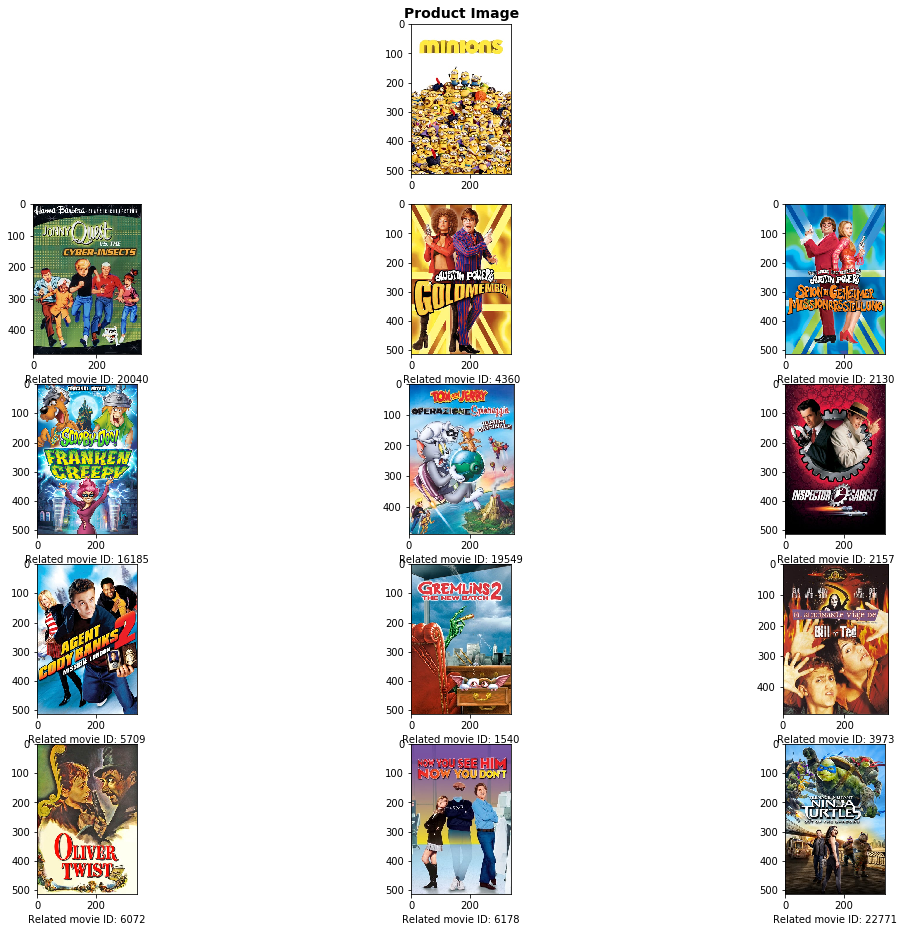

In [136]:
get_related_movies('tt2293640')

In [144]:
data.loc[data.original_title.str.contains('Man of Steel')]

imdb_id original_title                                    genres  \
13859  tt0770828   Man of Steel  Action,Adventure,Fantasy,Science,Fiction   

                                           modified_desc  
13859  young boy learns extraordinary powers earth yo...

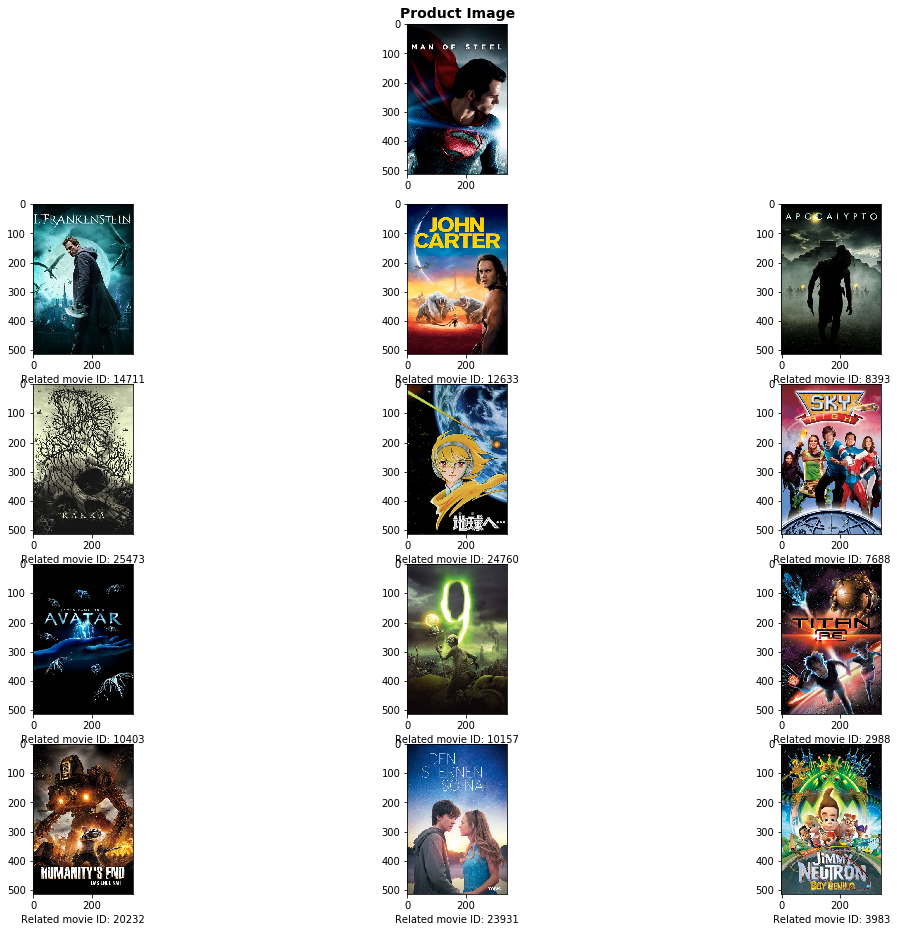

In [145]:
get_related_movies('tt0770828')

In [149]:
data['genres'].loc[[14711, 12633, 8393, 25473, 24760, 7688, 10403, 10157, 2988, 20232, 23931, 3983]]

14711                                      Horror,Thriller
12633                     Action,Adventure,Science,Fiction
8393                       Action,Adventure,Drama,Thriller
25473                               Action,Science,Fiction
24760           Animation,Adventure,Action,Science,Fiction
7688                               Adventure,Comedy,Family
10403             Action,Adventure,Fantasy,Science,Fiction
10157    Action,Adventure,Animation,Science,Fiction,Thr...
2988     Animation,Action,Science,Fiction,Family,Adventure
20232      Action,Adventure,Drama,Science,Fiction,Thriller
23931              Romance,Adventure,Science,Fiction,Drama
3983     Action,Adventure,Animation,Comedy,Family,Fanta...
Name: genres, dtype: object

In [146]:
data.loc[data.original_title.str.contains('Gravity')]

imdb_id   original_title                          genres  \
2847   tt0156460  Defying Gravity                   Drama,Romance   
11943  tt0104693  Laws of Gravity                    Action,Drama   
14155  tt1454468          Gravity  Science,Fiction,Thriller,Drama   

                                           modified_desc  
2847   john keitel wrote film based personal undergra...  
11943  jimmy jon couple brooklyn guys somehow never f...  
14155  dr ryan stone brilliant medical engineer first...

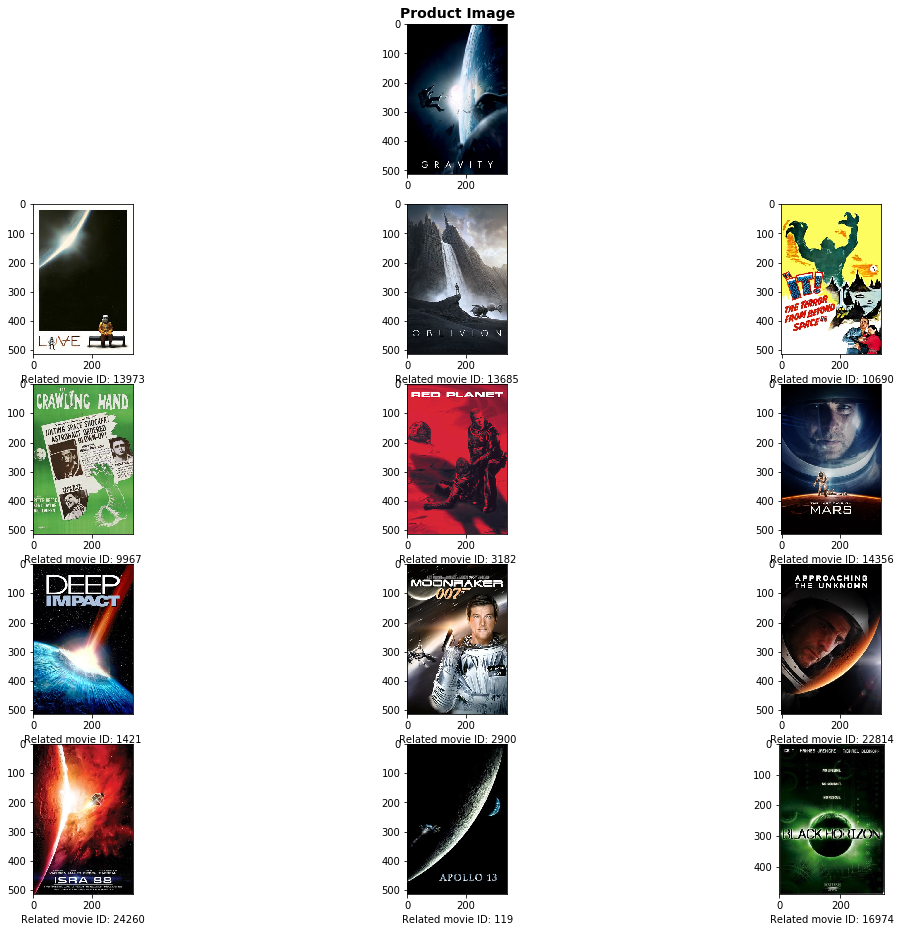

In [147]:
get_related_movies('tt1454468')

In [151]:
data.loc[10403]

imdb_id                                                   tt0499549
original_title                                               Avatar
genres                     Action,Adventure,Fantasy,Science,Fiction
modified_desc     22nd century paraplegic marine dispatched moon...
Name: 10403, dtype: object

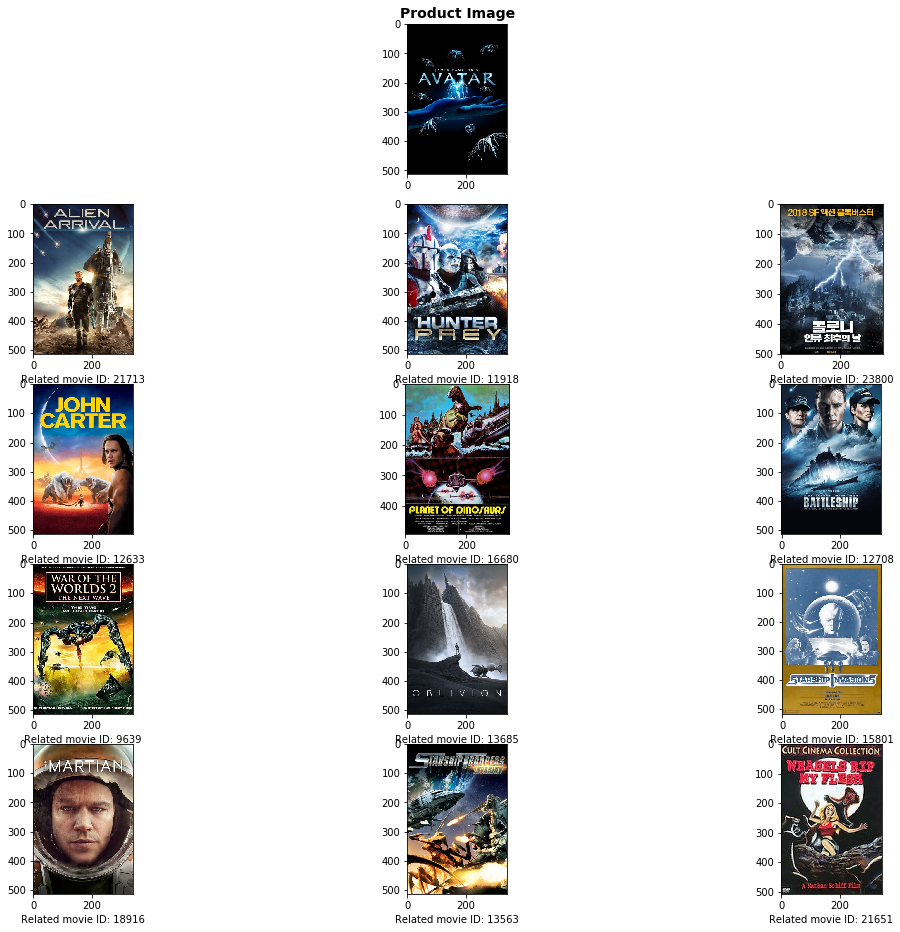

In [152]:
get_related_movies('tt0499549')